In [1]:
import os

from astropy.io import fits
from astropy.io import ascii as asc
from astropy.time import Time
import astropy.constants as c
import astropy.units as u
from astropy.modeling import models, fitting
import numpy as np
from matplotlib import pyplot as plt
%matplotlib
import matplotlib
from matplotlib.ticker import MultipleLocator

import spectroscopy as spec
import visualization as vis
import supernova

plt.style.use('default')

Using matplotlib backend: Qt5Agg


In [2]:
cols = [(0,0,0)]
for x in np.linspace(0,1, 254):
    rcol = (0.472-0.567*x+4.05*x**2)/(1.+8.72*x-19.17*x**2+14.1*x**3)
    gcol = 0.108932-1.22635*x+27.284*x**2-98.577*x**3+163.3*x**4-131.395*x**5+40.634*x**6
    bcol = 1./(1.97+3.54*x-68.5*x**2+243*x**3-297*x**4+125*x**5)
    cols.append((rcol, gcol, bcol))

cols.append((1,1,1))
cm_rainbow = matplotlib.colors.LinearSegmentedColormap.from_list("PaulT_rainbow", cols)

# Plot HA, Hb evolution Series

In [5]:
sn15oz = supernova.LightCurve2('asassn-15oz')

In [6]:
def read_iraf_spectrum(filename):
    ofile = fits.open(filename)
    flux = ofile[0].data[0,0,:]
    wave = spec.calc_wavelength(ofile[0].header, np.arange(len(flux))+1)
    rest_wave = spec.apply_redshift(wave, 0.0069)
    return(spec.spectrum1d(rest_wave, flux))

In [7]:
def calc_velocity(obs_wl, rest_wl):
    velocity = c.c*(obs_wl/rest_wl - 1)
    return velocity

In [8]:
VEL_DATA_DIR = '../data/line_info/'
DATA_DIR_LCO = '../data/spectra/lco'
DATA_DIR_EFOSC = '../data/spectra/EFOSC'
IRTF_DIR = '../data/spectra/IRTF/'
SOFI_DIR = '../data/spectra/SOFI'

In [9]:
z = 0.0069 #15oz redshift
Ha = 6563.0
Hb = 4850.0
HeI = 10830.0
CI = 10691.0
paschen_g = 10940.0
paschen_d = 10050.0
FeII = 5169.0
IR_dates = Time(['2015-09-05','2015-10-05', '2015-10-10'])

In [10]:
spectra_files = [
         ('asassn15oz_20150904_redblu_122216.314.fits', DATA_DIR_LCO),
         ('asassn-15oz_20150906_redblu_105042.698a.fits', DATA_DIR_LCO),
         ('asassn15oz_20150907_redblu_123835.277.fits', DATA_DIR_LCO),
         ('asassn15oz_20150911_redblu_105336.349.fits', DATA_DIR_LCO),
         ('asassn15oz_20150916_redblu_120911.274.fits', DATA_DIR_LCO),
         ('asassn-15oz_20150920_redblu_135034.512.fits',DATA_DIR_LCO),
         ('asassn-15oz_20150924_redblu_123847.580.fits',DATA_DIR_LCO),
         #('asassn-15oz_20150930_redblu_122858.217.fits',DATA_DIR_LCO),
         ('tASASSN-15oz_20151003_Gr13_Free_slit1.0_57720_1_e.fits',DATA_DIR_EFOSC),
         #('asassn15oz_20151006_redblu_101906.800.fits', DATA_DIR_LCO),
         #('asassn15oz_20151014_redblu_112918.305.fits', DATA_DIR_LCO),
         ('asassn-15oz_20151025_redblu_102221.833.fits', DATA_DIR_LCO),
         #('asassn-15oz_20151107_redblu_101210.833.fits', DATA_DIR_LCO),
         ('tASAS-SN_15oz_20151107_Gr13_Free_slit1.5_57723_1_e.fits', DATA_DIR_EFOSC),
         ('tASAS-SN_15oz_20151118_Gr13_Free_slit1.0_57723_1_e.fits', DATA_DIR_EFOSC)
                ]

In [11]:
tbdata_sofi1_blue = fits.getdata(os.path.join(SOFI_DIR, 'asassn15oz_20150905_2457270.58657_1.fits'), 1) #wave, flux, err, skyback
tbdata_sofi2_blue = fits.getdata(os.path.join(SOFI_DIR, 'asassn15oz_20151005_2457300.50252_1.fits'), 1)
#Date-obs: 2015-10-10
tbdata_irtf = asc.read(os.path.join(IRTF_DIR, 'A15oz_merge.txt'), names=['wave', 'flux', 'err', 'junk'])

In [12]:
spec_sofi1 = spec.spectrum1d(spec.apply_redshift(tbdata_sofi1_blue['WAVE'][0], z), tbdata_sofi1_blue['flux'][0], tbdata_sofi1_blue['err'])
spec_sofi2 = spec.spectrum1d(spec.apply_redshift(tbdata_sofi2_blue['WAVE'][0], z), tbdata_sofi2_blue['flux'][0], tbdata_sofi2_blue['err'])
spec_irtf = spec.spectrum1d(spec.apply_redshift(tbdata_irtf['wave']*10**4, z), tbdata_irtf['flux'], tbdata_irtf['err'])

In [13]:
tbdata_feII = asc.read(os.path.join(VEL_DATA_DIR, 'FeII_multi.tab'))
phase_feII = (Time(tbdata_feII['date'])-Time(sn15oz.jdexpl, format='jd')).value
velocity_feII = -1*calc_velocity(tbdata_feII['vel0'], FeII).to(u.km/u.s).value

new_fit_cachito = asc.read(os.path.join(VEL_DATA_DIR, 'cachito.tab'))
phase_cachito = (Time(new_fit_cachito['date'])-Time(sn15oz.jdexpl, format='jd')).value
velocity_cachito = -1*calc_velocity(new_fit_cachito['vel0'], Ha).to(u.km/u.s).value

fitter_power = fitting.LevMarLSQFitter()
power_model = models.PowerLaw1D()
power_fit_cachito = fitter_power(power_model, phase_cachito, velocity_cachito)

#I had trouble fitting without good starting parameters, cachito looks like FeII, especially at early times
power_model_feII = models.PowerLaw1D(alpha=power_fit_cachito.alpha, x_0=power_fit_cachito.x_0) 
power_fit_feII = fitter_power(power_model_feII, phase_feII, velocity_feII)
feII_velocity = power_fit_feII((IR_dates-Time(sn15oz.jdexpl, format='jd')).value)

paschen_g_wave = (feII_velocity*(u.km/u.s)/(c.c.to(u.km/u.s))+1)*paschen_g
paschen_g_HeI_vel = calc_velocity(paschen_g_wave, HeI).to(u.km/u.s)
paschen_g_rest_HeI_vel = calc_velocity(paschen_g, HeI).to(u.km/u.s)

paschen_d_wave = (feII_velocity*(u.km/u.s)/(c.c.to(u.km/u.s))+1)*paschen_d
paschen_d_HeI_vel = calc_velocity(paschen_d_wave, HeI).to(u.km/u.s)
paschen_d_rest_HeI_vel = calc_velocity(paschen_d, HeI).to(u.km/u.s)

CI_wave = (feII_velocity*(u.km/u.s)/(c.c.to(u.km/u.s))+1)*CI
CI_HeI_vel = calc_velocity(CI_wave, HeI).to(u.km/u.s)
print(paschen_g_HeI_vel)
print(paschen_d_HeI_vel)

[ 13055.14011179   9505.22621916   9280.54287735] km / s
[-12395.89849146 -15657.01682975 -15863.42154503] km / s


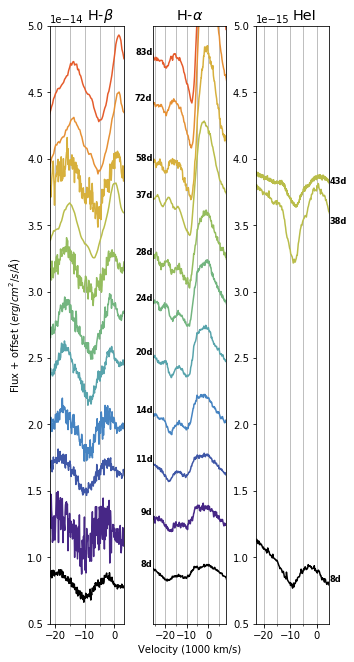

In [14]:
plt.close()
fig = plt.figure(figsize=[5, 11])
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,1)
ax3 = fig.add_subplot(1,3,3)
offset = np.arange(len(spectra_files))*0.4E-14
ref_spec = read_iraf_spectrum(os.path.join(spectra_files[0][1], spectra_files[0][0]))
#Consider making this all one color
colors = vis.make_color_wheel(spectra_files+[1], cmap=cm_rainbow)

for indx, ifile in enumerate(spectra_files):
    filename, idir = ifile
    ispec = read_iraf_spectrum(os.path.join(idir, filename))
    scale_ispec = spec.scale_spectra(ispec, ref_spec)
    ha_velocity = calc_velocity(scale_ispec.wave, Ha).to(u.km/u.s)
    hb_velocity = calc_velocity(scale_ispec.wave, Hb).to(u.km/u.s)
    ax1.plot(ha_velocity/1000, scale_ispec.flux+offset[indx], color=colors[indx])
    date = Time(fits.getval(os.path.join(idir, filename), 'date-obs', 0), out_subfmt='date')
    text_indx = np.where((scale_ispec.wave < 7000)&(scale_ispec.wave > 6000))[0]
    ax1.text(-26, (scale_ispec.flux+offset[indx])[text_indx[0]], '{}d'.format(int((date-Time(sn15oz.jdexpl, format='jd')).value)), 
             fontsize='small', ha='right', va='bottom', fontweight='bold', color='k')
    ax2.plot(hb_velocity/1000, scale_ispec.flux+offset[indx], color=colors[indx])

scale_sofi1 = spec.scale_spectra(spec_sofi1, spec_sofi2) #SOFI1
scale_irtf = spec.scale_spectra(spec_irtf, spec_sofi2) #IRTF
heI_velocity_sofi2 = calc_velocity(spec_sofi2.wave, HeI).to(u.km/u.s)
heI_velocity_sofi1 = calc_velocity(scale_sofi1.wave, HeI).to(u.km/u.s)
heI_velocity_irtf = calc_velocity(scale_irtf.wave, HeI).to(u.km/u.s)

ax3.plot(heI_velocity_sofi1/1000, scale_sofi1.flux, color=colors[0])
ax3.text(5, 0.8E-15, '{}d'.format(int((Time('2015-09-05')-Time(sn15oz.jdexpl, format='jd')).value)), 
             fontsize='small', ha='left', va='bottom', fontweight='bold', color='k')

ax3.plot(heI_velocity_sofi2/1000, spec_sofi2.flux+2.7E-15, color=colors[-5])
ax3.text(5, 3.5E-15, '{}d'.format(int((Time('2015-10-05')-Time(sn15oz.jdexpl, format='jd')).value)), 
             fontsize='small', ha='left', va='bottom', fontweight='bold', color='k')
ax3.plot(heI_velocity_irtf/1000, scale_irtf.flux+3.5E-15, color=colors[-5])
ax3.text(5, 3.8E-15, '{}d'.format(int((Time('2015-10-10')-Time(sn15oz.jdexpl, format='jd')).value)), 
             fontsize='small', ha='left', va='bottom', fontweight='bold', color='k')

ax1.set_xticks([-20, -10, 0])
ax1.set_yticks([])
ax1.set_xlim(calc_velocity(6000, Ha).to(u.km/u.s).value/1000, calc_velocity(6750, Ha).to(u.km/u.s).value/1000)
ax1.set_ylim(0,0.5E-13)
ax1.set_xlabel('Velocity (1000 km/s)')
ax1.set_title(r'H-$\alpha$', fontsize='x-large')

ax2.set_xlim(calc_velocity(4500, Hb).to(u.km/u.s).value/1000, calc_velocity(4900, Hb).to(u.km/u.s).value/1000)
ax2.set_xticks([-20, -10, 0])
ax2.set_ylim(0.05E-13,0.5E-13)
#ax2.set_xlabel('Rest Wavelength ($\AA$)')
ax2.set_ylabel('Flux + offset ($erg/cm^2/s/\AA$)')
ax2.set_title(r'H-$\beta$', ha='left', fontsize='x-large')

ax3.set_ylim(0.05E-14,0.5E-14)
ax3.set_xlim(calc_velocity(10000, HeI).to(u.km/u.s).value/1000, calc_velocity(11000, HeI).to(u.km/u.s).value/1000)
#ax3.set_xlabel('Rest Wavelength ($\AA$)')
ax3.set_title(r'HeI', ha='left', fontsize='x-large')
ax3.set_xticks([-20, -10, 0])
minorLocator = MultipleLocator(5)
ax1.xaxis.set_minor_locator(minorLocator)
ax1.grid(which='minor', axis='x')
ax2.xaxis.set_minor_locator(minorLocator)
ax2.grid(which='minor', axis='x')
ax3.xaxis.set_minor_locator(minorLocator)
ax3.grid(which='minor', axis='x')
plt.subplots_adjust(wspace=0.4)
plt.


# Look at IR

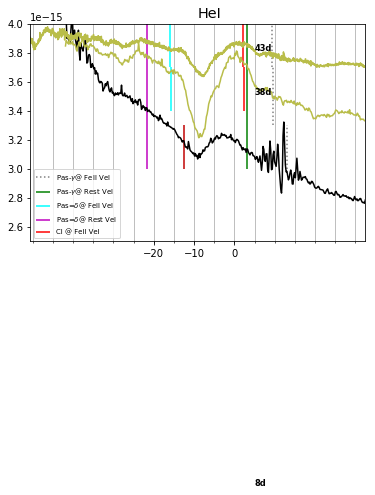

In [15]:
#plt.close()
fig = plt.figure()
ax3 = fig.add_subplot(1,1,1)

scale_sofi1 = spec.scale_spectra(spec_sofi1, spec_sofi2) #SOFI1
scale_irtf = spec.scale_spectra(spec_irtf, spec_sofi2) #IRTF
heI_velocity_sofi2 = calc_velocity(spec_sofi2.wave, HeI).to(u.km/u.s)
heI_velocity_sofi1 = calc_velocity(scale_sofi1.wave, HeI).to(u.km/u.s)
heI_velocity_irtf = calc_velocity(scale_irtf.wave, HeI).to(u.km/u.s)

ax3.plot(heI_velocity_sofi1/1000, scale_sofi1.flux+2.3E-15, color=colors[0])
ax3.text(5, 0.8E-15, '{}d'.format(int((Time('2015-09-05')-Time(sn15oz.jdexpl, format='jd')).value)), 
             fontsize='small', ha='left', va='bottom', fontweight='bold', color='k')

ax3.plot(heI_velocity_sofi2/1000, spec_sofi2.flux+2.7E-15, color=colors[-5])
ax3.text(5, 3.5E-15, '{}d'.format(int((Time('2015-10-05')-Time(sn15oz.jdexpl, format='jd')).value)), 
             fontsize='small', ha='left', va='bottom', fontweight='bold', color='k')
ax3.plot(heI_velocity_irtf/1000, scale_irtf.flux+3.5E-15, color=colors[-5])
ax3.text(5, 3.8E-15, '{}d'.format(int((Time('2015-10-10')-Time(sn15oz.jdexpl, format='jd')).value)), 
             fontsize='small', ha='left', va='bottom', fontweight='bold', color='k')

l = ax3.vlines([paschen_g_HeI_vel[0].value/1000], ymin=3E-15, ymax=3.3E-15, linestyle=':', color='Gray', label=r'Pas-$\gamma$')
ax3.vlines([paschen_g_HeI_vel[1].value/1000], ymin=3.3E-15, ymax=3.7E-15, linestyle=':', color='Gray')
ax3.vlines([paschen_g_HeI_vel[2].value/1000], ymin=3.7E-15, ymax=4.0E-15, linestyle=':', color='Gray')

l1 = ax3.vlines([paschen_g_rest_HeI_vel.value/1000], ymin=3E-15, ymax=4E-15, linestyle='-', color='g', label=r'Pas-$\gamma$ Rest')

l2 = ax3.vlines([paschen_d_HeI_vel[0].value/1000], ymin=3E-15, ymax=3.3E-15, linestyle='-', color='cyan', label=r'Pas-$\delta$')
ax3.vlines([paschen_d_HeI_vel[1].value/1000], ymin=3.4E-15, ymax=3.7E-15, linestyle='-', color='cyan')
ax3.vlines([paschen_d_HeI_vel[2].value/1000], ymin=3.7E-15, ymax=4.0E-15, linestyle='-', color='cyan')

l3 = ax3.vlines([paschen_d_rest_HeI_vel.value/1000], ymin=3E-15, ymax=4.0E-15, linestyle='-', color='m', label=r'Pas-$\delta$ Rest')

l4 = ax3.vlines([paschen_d_HeI_vel[0].value/1000], ymin=3E-15, ymax=3.3E-15, linestyle='-', color='r', label=r'Pas-$\delta$')
ax3.vlines([CI_HeI_vel[1].value/1000], ymin=3.4E-15, ymax=3.7E-15, linestyle='-', color='r')
ax3.vlines([CI_HeI_vel[2].value/1000], ymin=3.7E-15, ymax=4.0E-15, linestyle='-', color='r')


ax3.legend([l, l1, l2, l3, l4], [r'Pas-$\gamma$@ FeII Vel',r'Pas-$\gamma$@ Rest Vel', r'Pas=$\delta$@ FeII Vel', r'Pas=$\delta$@ Rest Vel', r'CI @ FeII Vel'], fontsize='x-small')

ax3.set_ylim(2.5E-15, 4.0E-15)
ax3.set_xlim(calc_velocity(9000, HeI).to(u.km/u.s).value/1000, calc_velocity(12000, HeI).to(u.km/u.s).value/1000)
#ax3.set_xlabel('Rest Wavelength ($\AA$)')
ax3.set_title(r'HeI', ha='left', fontsize='x-large')
ax3.set_xticks([-20, -10, 0])
minorLocator = MultipleLocator(5)

ax3.xaxis.set_minor_locator(minorLocator)
ax3.grid(which='minor', axis='x')
plt.subplots_adjust(wspace=0.4)